# price.py

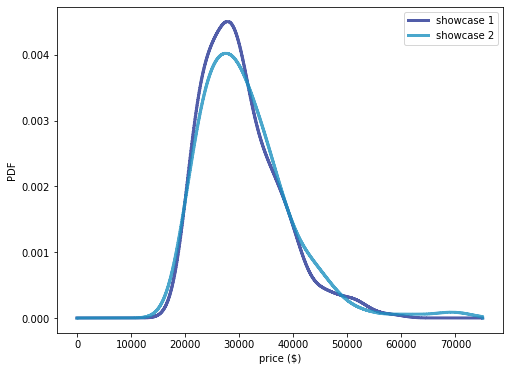

Player median 3902
Player median 3136
Player 1 overbids 0.24600638977635783
Player 2 overbids 0.29073482428115016


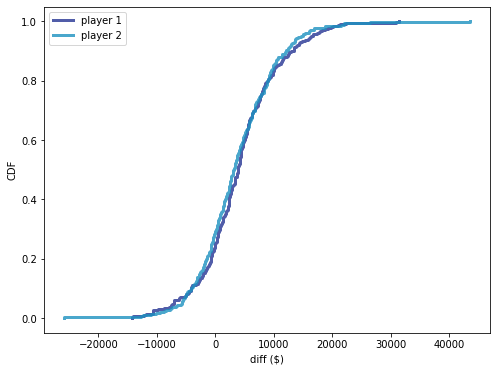

Player 1 prior mle 27825.0
Player 2 prior mle 27525.0
Player 1 mean 25096.41181620626
Player 2 mean 35641.21685180631
Player 1 mle 23775.0
Player 2 mle 35175.0


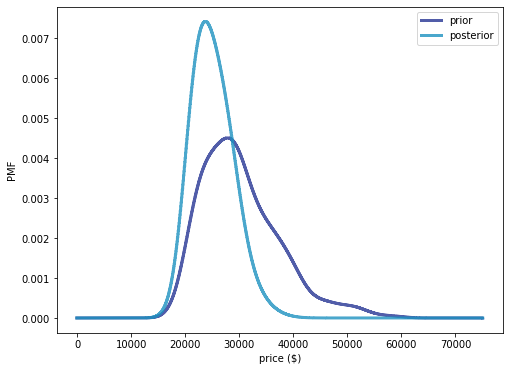

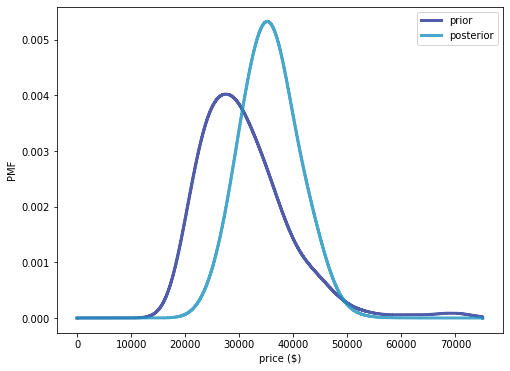

Player 1 optimal bid (15455.101929534305, 20250.0)
Player 2 optimal bid (18048.447098541343, 30750.0)


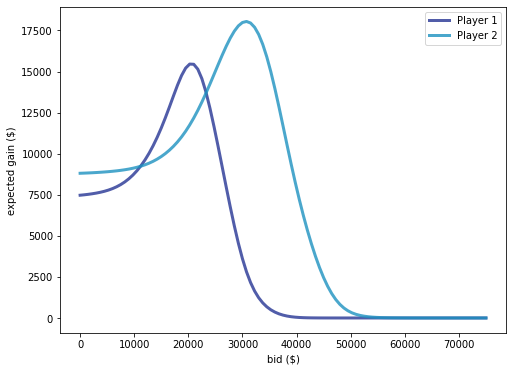

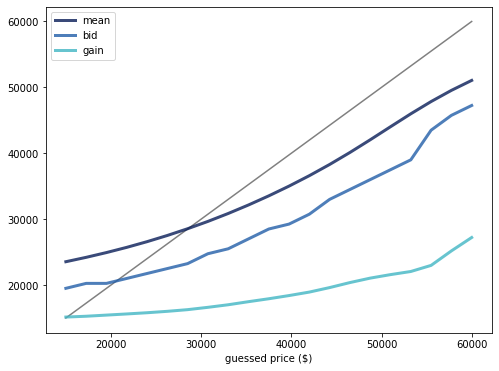

<Figure size 576x432 with 0 Axes>

In [7]:
"""This file contains code for use with "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2013 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""
from __future__ import print_function

import sys
sys.path.append("../code/")

import csv
import numpy
import thinkbayes
import thinkplot

import matplotlib.pyplot as pyplot

file_path = "../code/"
FORMATS = ['png', 'pdf', 'eps']


def ReadData(filename=file_path+'showcases.2011.csv'):
    """Reads a CSV file of data.

    Args:
      filename: string filename

    Returns: sequence of (price1 price2 bid1 bid2 diff1 diff2) tuples
    """
    fp = open(filename)
    reader = csv.reader(fp)
    res = []

    for t in reader:
        _heading = t[0]
        data = t[1:]
        try:
            data = [int(x) for x in data]
            # print(heading, data[0], len(data))
            res.append(data)
        except ValueError:
            pass

    fp.close()
    return list(zip(*res))
    

class Price(thinkbayes.Suite):
    """Represents hypotheses about the price of a showcase."""

    def __init__(self, pmf, player, name=''):
        """Constructs the suite.

        pmf: prior distribution of price
        player: Player object
        name: string
        """
        thinkbayes.Suite.__init__(self, pmf, name=name)
        self.player = player

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: actual price
        data: the contestant's guess
        """
        price = hypo
        guess = data

        error = price - guess
        like = self.player.ErrorDensity(error)

        return like


class GainCalculator(object):
    """Encapsulates computation of expected gain."""

    def __init__(self, player, opponent):
        """Constructs the calculator.

        player: Player
        opponent: Player
        """
        self.player = player
        self.opponent = opponent

    def ExpectedGains(self, low=0, high=75000, n=101):
        """Computes expected gains for a range of bids.

        low: low bid
        high: high bid
        n: number of bids to evaluates

        returns: tuple (sequence of bids, sequence of gains)
    
        """
        bids = numpy.linspace(low, high, n)

        gains = [self.ExpectedGain(bid) for bid in bids]

        return bids, gains

    def ExpectedGain(self, bid):
        """Computes the expected return of a given bid.

        bid: your bid
        """
        suite = self.player.posterior
        total = 0
        for price, prob in sorted(suite.Items()):
            gain = self.Gain(bid, price)
            total += prob * gain
        return total

    def Gain(self, bid, price):
        """Computes the return of a bid, given the actual price.

        bid: number
        price: actual price
        """
        # if you overbid, you get nothing
        if bid > price:
            return 0

        # otherwise compute the probability of winning
        diff = price - bid
        prob = self.ProbWin(diff)

        # if you are within 250 dollars, you win both showcases
        if diff <= 250:
            return 2 * price * prob
        else:
            return price * prob

    def ProbWin(self, diff):
        """Computes the probability of winning for a given diff.

        diff: how much your bid was off by
        """
        prob = (self.opponent.ProbOverbid() + 
                self.opponent.ProbWorseThan(diff))
        return prob


class Player(object):
    """Represents a player on The Price is Right."""

    n = 1001  # instead of 101, to make the plot smoother
    price_xs = numpy.linspace(0, 75000, n)

    def __init__(self, prices, bids, diffs):
        """Construct the Player.

        prices: sequence of prices
        bids: sequence of bids
        diffs: sequence of underness (negative means over)
        """
        self.pdf_price = thinkbayes.EstimatedPdf(prices)
        self.cdf_diff = thinkbayes.MakeCdfFromList(diffs)

        mu = 0
        sigma = numpy.std(diffs)
        self.pdf_error = thinkbayes.GaussianPdf(mu, sigma)

    def ErrorDensity(self, error):
        """Density of the given error in the distribution of error.

        error: how much the bid is under the actual price
        """
        return self.pdf_error.Density(error)

    def PmfPrice(self):
        """Returns a new Pmf of prices.

        A discrete version of the estimated Pdf.
        """
        return self.pdf_price.MakePmf(self.price_xs)

    def CdfDiff(self):
        """Returns a reference to the Cdf of differences (underness).
        """
        return self.cdf_diff

    def ProbOverbid(self):
        """Returns the probability this player overbids.
        """
        return self.cdf_diff.Prob(-1)

    def ProbWorseThan(self, diff):
        """Probability this player's diff is greater than the given diff.

        diff: how much the oppenent is off by (always positive)
        """
        return 1 - self.cdf_diff.Prob(diff)

    def MakeBeliefs(self, guess):
        """Makes a posterior distribution based on estimated price.

        Sets attributes prior and posterior.

        guess: what the player thinks the showcase is worth        
        """
        pmf = self.PmfPrice()
        self.prior = Price(pmf, self, name='prior')
        self.posterior = self.prior.Copy(name='posterior')
        self.posterior.Update(guess)

    def OptimalBid(self, guess, opponent):
        """Computes the bid that maximizes expected return.
        
        guess: what the player thinks the showcase is worth 
        opponent: Player

        Returns: (optimal bid, expected gain)
        """
        self.MakeBeliefs(guess)
        calc = GainCalculator(self, opponent)
        bids, gains = calc.ExpectedGains()
        gain, bid = max(zip(gains, bids))
        return bid, gain

    def PlotBeliefs(self, root):
        """Plots prior and posterior beliefs.

        root: string filename root for saved figure
        """
        thinkplot.Clf()
        thinkplot.PrePlot(num=2)
        thinkplot.Pmfs([self.prior, self.posterior])
        thinkplot.Show(xlabel='price ($)',
                    ylabel='PMF')
#         thinkplot.Save(root=root,
#                     xlabel='price ($)',
#                     ylabel='PMF',
#                     formats=FORMATS)


def MakePlots(player1, player2):
    """Generates two plots.

    price1 shows the priors for the two players
    price2 shows the distribution of diff for the two players
    """

    # plot the prior distribution of price for both players
    thinkplot.Clf()
    thinkplot.PrePlot(num=2)
    pmf1 = player1.PmfPrice()
    pmf1.name = 'showcase 1'
    pmf2 = player2.PmfPrice()
    pmf2.name = 'showcase 2'
    thinkplot.Pmfs([pmf1, pmf2])
    thinkplot.Show(xlabel='price ($)',
                ylabel='PDF')
#     thinkplot.Save(root='price1',
#                 xlabel='price ($)',
#                 ylabel='PDF',
#                 formats=FORMATS)

    # plot the historical distribution of underness for both players
    thinkplot.Clf()
    thinkplot.PrePlot(num=2)
    cdf1 = player1.CdfDiff()
    cdf1.name = 'player 1'
    cdf2 = player2.CdfDiff()
    cdf2.name = 'player 2'

    print('Player median', cdf1.Percentile(50))
    print('Player median', cdf2.Percentile(50))

    print('Player 1 overbids', player1.ProbOverbid())
    print('Player 2 overbids', player2.ProbOverbid())

    thinkplot.Cdfs([cdf1, cdf2])
    thinkplot.Show(xlabel='diff ($)',
                ylabel='CDF')
#     thinkplot.Save(root='price2',
#                 xlabel='diff ($)',
#                 ylabel='CDF',
#                 formats=FORMATS)


def MakePlayers():
    """Reads data and makes player objects."""
    data = ReadData(filename=file_path+'showcases.2011.csv')
    data += ReadData(filename=file_path+'showcases.2012.csv')

    cols = zip(*data)
    price1, price2, bid1, bid2, diff1, diff2 = cols

    # print(list(sorted(price1)))
    # print(len(price1))

    player1 = Player(price1, bid1, diff1)
    player2 = Player(price2, bid2, diff2)

    return player1, player2


def PlotExpectedGains(guess1=20000, guess2=40000):
    """Plots expected gains as a function of bid.

    guess1: player1's estimate of the price of showcase 1
    guess2: player2's estimate of the price of showcase 2
    """
    player1, player2 = MakePlayers()
    MakePlots(player1, player2)

    player1.MakeBeliefs(guess1)
    player2.MakeBeliefs(guess2)

    print('Player 1 prior mle', player1.prior.MaximumLikelihood())
    print('Player 2 prior mle', player2.prior.MaximumLikelihood())
    print('Player 1 mean', player1.posterior.Mean())
    print('Player 2 mean', player2.posterior.Mean())
    print('Player 1 mle', player1.posterior.MaximumLikelihood())
    print('Player 2 mle', player2.posterior.MaximumLikelihood())

    player1.PlotBeliefs('price3')
    player2.PlotBeliefs('price4')

    calc1 = GainCalculator(player1, player2)
    calc2 = GainCalculator(player2, player1)

    thinkplot.Clf()
    thinkplot.PrePlot(num=2)w

    bids, gains = calc1.ExpectedGains()
    thinkplot.Plot(bids, gains, label='Player 1')
    print('Player 1 optimal bid', max(zip(gains, bids)))

    bids, gains = calc2.ExpectedGains()
    thinkplot.Plot(bids, gains, label='Player 2')
    print('Player 2 optimal bid', max(zip(gains, bids)))
    thinkplot.Show(xlabel='bid ($)',
                ylabel='expected gain ($)')
#     thinkplot.Save(root='price5',
#                 xlabel='bid ($)',
#                 ylabel='expected gain ($)',
#                 formats=FORMATS)


def PlotOptimalBid():
    """Plots optimal bid vs estimated price.
    """
    player1, player2 = MakePlayers()
    guesses = numpy.linspace(15000, 60000, 21)

    res = []
    for guess in guesses:
        player1.MakeBeliefs(guess)

        mean = player1.posterior.Mean()
        mle = player1.posterior.MaximumLikelihood()

        calc = GainCalculator(player1, player2)
        bids, gains = calc.ExpectedGains()
        gain, bid = max(zip(gains, bids))

        res.append((guess, mean, mle, gain, bid))

    guesses, means, _mles, gains, bids = zip(*res)
    
    thinkplot.PrePlot(num=3)
    pyplot.plot([15000, 60000], [15000, 60000], color='gray')
    thinkplot.Plot(guesses, means, label='mean')
    #thinkplot.Plot(guesses, mles, label='MLE')
    thinkplot.Plot(guesses, bids, label='bid')
    thinkplot.Plot(guesses, gains, label='gain')
    thinkplot.Show(xlabel='guessed price ($)')
#     thinkplot.Save(root='price6',
#                    xlabel='guessed price ($)',
#                    formats=FORMATS)


def TestCode(calc):
    """Check some intermediate results.

    calc: GainCalculator
    """
    # test ProbWin
    for diff in [0, 100, 1000, 10000, 20000]:
        print(diff, calc.ProbWin(diff))
    print

    # test Return
    price = 20000
    for bid in [17000, 18000, 19000, 19500, 19800, 20001]:
        print(bid, calc.Gain(bid, price))
    print


def main():
    PlotExpectedGains()
    PlotOptimalBid()



if __name__ == '__main__':
    main()


showcase: 真实价格
bid: 猜测价格